1. Add class to DataSet
2. Add class to training loop
3. Add class to generation -> DDPMPipeline doesnt accept text conditioning
    1. Custom DDPMPipeline
4. Add class to CustomModel
5. Change everything to video
    * make sure dimensions match

In [1]:
# Imports
import librosa
import matplotlib.pyplot as plt
import numpy as np
import torch
from diffusers import StableDiffusionPipeline

/accounts/class/s222/deepul_vidaud/.local/lib/python3.11/site-packages/transformers/utils/hub.py:124: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(
2024-04-12 17:01:10.448862: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-12 17:01:10.501770: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-12 17:01:12.026187: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
import torch

if torch.cuda.is_available():
    print("CUDA is available")
else:
    print("CUDA is not available")

CUDA is available


# Wav to Melspec
TODO: change to torch functions for better performance

In [148]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import torch
from diffusers import StableDiffusionPipeline
import torch
from PIL import Image
import numpy as np
from diffusers import DDPMScheduler
from diffusers.optimization import get_cosine_schedule_with_warmup
from torchvision import transforms
import torch.nn.functional as F
from diffusers import DDPMPipeline, DiffusionPipeline, ImagePipelineOutput
from diffusers.utils import make_image_grid
import os

from accelerate import Accelerator
from huggingface_hub import create_repo, upload_folder
from tqdm.auto import tqdm
from pathlib import Path
import os

from torchvision import transforms
import torch
import torch.nn.functional as F

In [5]:
def pad_or_truncate(mel_spec, max_length, axis=-1):
    current_length = mel_spec.shape[axis]
    if current_length < max_length:
        padding = max_length - current_length
        pad_width = [(0, 0)] * mel_spec.ndim
        pad_width[axis] = (0, padding)
        mel_spec_padded = np.pad(mel_spec, pad_width, mode='constant')
        return mel_spec_padded
    elif current_length > max_length:
        return mel_spec[..., :max_length]
    else:
        return mel_spec

In [14]:
# Convert wav to melspectrograms

In [6]:
import os

wav_folder_path = 'data/free-spoken-digit-dataset-master/recordings'
mel_folder_path = 'data/free-spoken-digit-dataset-master/melspecs'
os.makedirs(mel_folder_path, exist_ok=True)

# Determine the maximum length of the mel spectrograms
max_length = 0
for wav_file in os.listdir(wav_folder_path):
    if wav_file.endswith('.wav'):
        file_path = os.path.join(wav_folder_path, wav_file)
        mel_spec = wav_to_mel(file_path)
        if mel_spec.shape[1] > max_length:
            max_length = mel_spec.shape[1]
            
max_length = 32

print("Starting conversion.")
            
# Convert, pad, and save the mel spectrograms
for wav_file in os.listdir(wav_folder_path):
    if wav_file.endswith('.wav'):
        file_path = os.path.join(wav_folder_path, wav_file)
        mel_spec = wav_to_mel(file_path)
        mel_spec_padded = pad_or_truncate(mel_spec, max_length)
        mel_file_path = os.path.join(mel_folder_path, os.path.splitext(wav_file)[0] + '.npy')
        np.save(mel_file_path, mel_spec_padded)

print('Conversion complete.')

Starting conversion.
Conversion complete.


# Melspec as tensor dataset 

In [83]:
int('0')

0

In [129]:
import torch
from torch.utils.data import Dataset
from torchvision import transforms
import glob


class MelSpectrogramDataset(Dataset):
    def __init__(self, mel_folder_path, transform=None):
        self.mel_folder_path = mel_folder_path
        self.mel_files = [f for f in os.listdir(mel_folder_path) if f.endswith('.npy')]
        self.transform = transform
        self.unique_classes = set()
        self.num_classes = 0

    def __len__(self):
        return len(self.mel_files)

    def __getitem__(self, idx):
        mel_file_path = os.path.join(self.mel_folder_path, self.mel_files[idx])
        mel_spec = np.load(mel_file_path)
        # class is indicated in the file as '<class>_*.npy'
        label = int(self.mel_files[idx].split('_')[0]) # TODO : change label to video embedding
        self.unique_classes = self.unique_classes.union({label})
        self.num_classes = len(self.unique_classes)
        label = torch.tensor(label,dtype=int)
        if self.transform:
            mel_spec = self.transform(mel_spec)
        if isinstance(mel_spec, np.ndarray):
            mel_spec = torch.from_numpy(mel_spec).float().clone().detach()
        elif isinstance(mel_spec, torch.Tensor):
            mel_spec = mel_spec.float().clone().detach()
        else:
            raise TypeError(f"Expected mel_spec to be np.ndarray or torch.Tensor, got {type(mel_spec)}")
        return mel_spec,label
    
    
    def set_transform(self, transform):
        self.transform = transform

class DuplicateChannels:
    def __call__(self, mel_spec):
        #return torch.stack([mel_spec.unsqueeze(0)] * 3, dim=0)
        return np.stack([mel_spec] * 3, axis=0)
        
    
class ScaleToRange:
    def __init__(self, min_value, max_value, target_range=(-1, 1)):
        self.min_value = min_value
        self.max_value = max_value
        self.target_min, self.target_max = target_range

    def __call__(self, tensor):
        # Scale to [0, 1]
        tensor = (tensor - self.min_value) / (self.max_value - self.min_value)
        # Scale to target range
        tensor = tensor * (self.target_max - self.target_min) + self.target_min
        return tensor

class ResizeAndDuplicate:
    def __init__(self, output_size):
        self.output_size = output_size

    def __call__(self, tensor):
        # Add a channel dimension
        tensor = tensor.unsqueeze(0)
        # Resize
        tensor = F.interpolate(tensor.unsqueeze(0), size=self.output_size, mode='bilinear', align_corners=False).squeeze(0)
        # Duplicate along the channel dimension
        tensor = tensor.repeat(3, 1, 1)
        return tensor


In [130]:
wav_folder_path = 'data/free-spoken-digit-dataset-master/recordings'
mel_folder_path = 'data/free-spoken-digit-dataset-master/melspecs'

# Create the dataset object and apply the transformations
mel_dataset = MelSpectrogramDataset(mel_folder_path)

min_value = float('inf')
max_value = float('-inf')

for mel_spec in mel_dataset:
    min_value = min(min_value, mel_spec[0].min().item())
    max_value = max(max_value, mel_spec[0].max().item())

print(f'Min value: {min_value}, Max value: {max_value}')
mel_dataset.num_classes

Min value: -80.0, Max value: 3.814697265625e-06


10

In [131]:
preprocess = transforms.Compose(
    [
        #TimeShift(),
        #FrequencyMask(max_width=10),
        DuplicateChannels(),
        transforms.Lambda(lambda x: torch.tensor(x, dtype=torch.float32)),  # Convert to tensor
        #ResizeAndDuplicate(output_size=(128, 128)),
        ScaleToRange(min_value, max_value)
    ]
)

mel_dataset.set_transform(preprocess)

In [132]:
transf_ms = mel_dataset[0][0].numpy()
print(transf_ms.shape)
print(transf_ms.min(), transf_ms.max())

(3, 128, 32)
-1.0 1.0


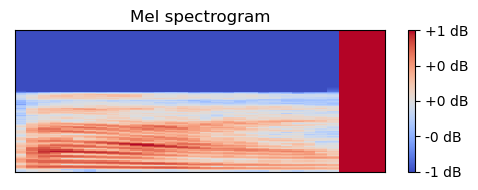

In [133]:
plt.figure(figsize=(5, 2))
librosa.display.specshow(transf_ms[0,:,:])
plt.colorbar(format='%+2.0f dB')
plt.title('Mel spectrogram')
plt.tight_layout()
plt.show()

In [209]:
from dataclasses import dataclass

@dataclass
class TrainingConfig:
    image_size = (128,32)  # the generated image resolution
    train_batch_size = 16
    eval_batch_size = 16  # how many images to sample during evaluation
    num_epochs = 5
    gradient_accumulation_steps = 1
    learning_rate = 1e-4
    lr_warmup_steps = 500
    save_image_epochs = 10
    save_model_epochs = 30
    mixed_precision = "fp16"  # `no` for float32, `fp16` for automatic mixed precision
    output_dir = "MNIST_Audio"  # the model name locally and on the HF Hub

    push_to_hub = False  # whether to upload the saved model to the HF Hub
    hub_model_id = "<your-username>/<my-awesome-model>"  # the name of the repository to create on the HF Hub
    hub_private_repo = False
    overwrite_output_dir = True  # overwrite the old model when re-running the notebook
    seed = 0


config = TrainingConfig()

In [210]:
# Create dataloader
train_dataloader = torch.utils.data.DataLoader(mel_dataset, batch_size=config.train_batch_size, shuffle=True)

# Train diffusion

In [211]:
# conditional model
from diffusers import UNet2DConditionModel

class UNet2DConditionCustomModel(UNet2DConditionModel):
    def __init__(
        self,
        
        **kwarg,
    ):
        super().__init__(**kwargs)

In [212]:
from diffusers import UNet2DModel

model = UNet2DModel(
    sample_size=config.image_size,  # the target image resolution
    in_channels=3,  # the number of input channels, 3 for RGB images
    out_channels=3,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(128, 128, 256, 256, 512, 512),  # the number of output channels for each UNet block
    down_block_types=(
        "DownBlock2D",  # a regular ResNet downsampling block
        "DownBlock2D",
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "DownBlock2D",
    ),
    up_block_types=(
        "UpBlock2D",  # a regular ResNet upsampling block
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
    ),
    class_embed_type = None,
    num_class_embeds = 10,
    # projection_class_embeddings_input_dim = 1
)

In [213]:
# Check input and output shape match
sample_image, image_class = mel_dataset[0]
sample_image = sample_image.unsqueeze(0)
# image_class = image_class.unsqueeze(0)
print("Input shape:", sample_image.shape)
print("Class shape:", image_class.shape)

print("Output shape:", model(sample = sample_image,class_labels = image_class, timestep=0).sample.shape)

Input shape: torch.Size([1, 3, 128, 32])
Class shape: torch.Size([])
Output shape: torch.Size([1, 3, 128, 32])


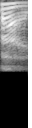

In [214]:
# Create scheduler
noise_scheduler = DDPMScheduler(num_train_timesteps=1000)
noise = torch.randn(sample_image.shape)
timesteps = torch.LongTensor([50])
noisy_image = noise_scheduler.add_noise(sample_image, noise, timesteps)

Image.fromarray(((noisy_image.permute(0, 2, 3, 1) + 1.0) * 127.5).type(torch.uint8).numpy()[0])
Image.fromarray(((sample_image.permute(0, 2, 3, 1) + 1.0) * 127.5).type(torch.uint8).numpy()[0])

In [215]:
# Loss calculation
noise_pred = model(sample =noisy_image, class_labels=image_class, timestep=timesteps).sample
loss = F.mse_loss(noise_pred, noise)

In [216]:
# optimizer and lr scheduler

optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate)
lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=config.lr_warmup_steps,
    num_training_steps=(len(train_dataloader) * config.num_epochs),
)

In [217]:
# post_processing
def reverse_transformations(numpy_images, min_value, max_value):
    reversed_images = []

    for image in numpy_images:
        # Reverse the duplication of channels (assuming the original image had 1 channel)
        image = image[:, :, 0]

        # Reverse the scaling to the original range
        image = ((image + 1) / 2) * (max_value - min_value) + min_value

        # Append the reversed image to the list
        reversed_images.append(image)

    return reversed_images


In [225]:
import warnings
from typing import Optional, Tuple, Union,List

class DDPMPipelineConditional(DDPMPipeline):
    r"""
    This model inherits from [`DDPMPipeline`]. Check the superclass documentation for the generic methods the
    library implements for all the pipelines (such as downloading or saving, running on a particular device, etc.)

    Parameters:
        unet ([`UNet2DModel`,`UNet2DConditionalModel`]): U-Net architecture to denoise the encoded image.
        scheduler ([`SchedulerMixin`]):
            A scheduler to be used in combination with `unet` to denoise the encoded image. Can be one of
            [`DDPMScheduler`], or [`DDIMScheduler`].
    """

    @torch.no_grad()
    def __call__(
        self,
        classes: List[int],
        n_timesteps: int,
        batch_size: int = 1,
        generator: Optional[torch.Generator] = None,
        output_type: Optional[str] = "pil",
        return_dict: bool = True,
        **kwargs,
    ) -> Union[ImagePipelineOutput, Tuple]:
        r"""
        Args:
            classes:
                List of classes to condition generation.
            n_timesteps:
                The number of denoising steps per sample.
            batch_size (`int`, *optional*, defaults to 1):
                The number of images to generate per class.
            generator (`torch.Generator`, *optional*):
                A [torch generator](https://pytorch.org/docs/stable/generated/torch.Generator.html) to make generation
                deterministic.
            output_type (`str`, *optional*, defaults to `"pil"`):
                The output format of the generate image. Choose between
                [PIL](https://pillow.readthedocs.io/en/stable/): `PIL.Image.Image` or `nd.array`.
            return_dict (`bool`, *optional*, defaults to `True`):
                Whether or not to return a [`~pipeline_utils.ImagePipelineOutput`] instead of a plain tuple.

        Returns:
            [`~pipeline_utils.ImagePipelineOutput`] or `tuple`: [`~pipelines.utils.ImagePipelineOutput`] if
            `return_dict` is True, otherwise a `tuple. When returning a tuple, the first element is a list with the
            generated images.
        """
        if "torch_device" in kwargs:
            device = kwargs.pop("torch_device")
            warnings.warn(
                "`torch_device` is deprecated as an input argument to `__call__` and will be removed in v0.3.0."
                " Consider using `pipe.to(torch_device)` instead."
            )
            # Set device as before (to be removed in 0.3.0)
            if device is None:
                device = "cuda" if torch.cuda.is_available() else "cpu"
            self.to(device)
        
        images = []
        # set step values
        self.scheduler.set_timesteps(n_timesteps)
        # loop thru classes
        for image_class in classes:
            # Sample gaussian noise to begin loop
            image = torch.randn(
                (batch_size, self.unet.in_channels, *self.unet.sample_size),
                generator=generator,
            )
            image = image.to(self.device)
            for t in self.progress_bar(self.scheduler.timesteps):
                # 1. predict noise model_output
                model_output = self.unet(sample=image,
                                         class_labels=torch.tensor(image_class,dtype=int,device=self.device),
                                         timestep=t).sample

                # 2. compute previous image: x_t -> t_t-1
                image = self.scheduler.step(model_output, t, image, generator=generator).prev_sample

            image = (image / 2 + 0.5).clamp(0, 1)
            image = image.cpu().permute(0, 2, 3, 1).numpy()
            images.append(image)
        images = np.concatenate(images)
        if output_type == "pil":
            images = self.numpy_to_pil(image)

        if not return_dict:
            return (images,)

        return ImagePipelineOutput(images=images)

In [227]:
def evaluate(config, epoch, pipeline, classes, n_timesteps=100, min_value=min_value, max_value=max_value):
    # Sample some images from random noise (this is the backward diffusion process).
    # The default pipeline output type is `List[PIL.Image]`
    images = pipeline(
        batch_size=config.eval_batch_size,
        generator=torch.manual_seed(config.seed),
        classes=classes,
        n_timesteps=n_timesteps
    ).images

    # Make a grid out of the images
    image_grid = make_image_grid(images, rows=4, cols=4)

    # Save the images
    test_dir = os.path.join(config.output_dir, "samples")
    os.makedirs(test_dir, exist_ok=True)
    image_grid.save(f"{test_dir}/{epoch:04d}.png")

    # Convert PIL images to numpy arrays
    numpy_images = [np.array(image) for image in images]
    numpy_images = [((image/255.0)-0.5)*2 for image in numpy_images]

    # Reverse the transformations
    reversed_images = reverse_transformations(numpy_images, min_value, max_value)

    # Save the individual numpy arrays
    test_dir = os.path.join(config.output_dir, "samples")
    os.makedirs(test_dir, exist_ok=True)
    for i, image in enumerate(reversed_images):
        np.save(os.path.join(test_dir, f"sample_{epoch:04d}_{i}.npy"), image)

    # Convert numpy arrays back to PIL images for saving (optional)
    pil_images = [Image.fromarray(np.uint8(image)) for image in reversed_images]

    # Make a grid out of the PIL images
    image_grid = make_image_grid(pil_images, rows=4, cols=4)

    # Save the grid of images
    image_grid.save(os.path.join(test_dir, f"grid_{epoch:04d}.png"))


In [231]:
from accelerate import Accelerator
from huggingface_hub import create_repo, upload_folder
from tqdm.auto import tqdm
from pathlib import Path
import os

loss_mod = 47
loss_visual = []

def train_loop(config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler):
    # Initialize accelerator and tensorboard logging
    accelerator = Accelerator(
        mixed_precision=config.mixed_precision,
        gradient_accumulation_steps=config.gradient_accumulation_steps,
        log_with="tensorboard",
        project_dir=os.path.join(config.output_dir, "logs"),
    )
    if accelerator.is_main_process:
        if config.output_dir is not None:
            os.makedirs(config.output_dir, exist_ok=True)
        if config.push_to_hub:
            repo_id = create_repo(
                repo_id=config.hub_model_id or Path(config.output_dir).name, exist_ok=True
            ).repo_id
        accelerator.init_trackers("train_example")

    # Prepare everything
    # There is no specific order to remember, you just need to unpack the
    # objects in the same order you gave them to the prepare method.
    model, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
        model, optimizer, train_dataloader, lr_scheduler
    )

    global_step = 0

    # Now you train the model
    for epoch in range(config.num_epochs):
        progress_bar = tqdm(total=len(train_dataloader), disable=not accelerator.is_local_main_process)
        progress_bar.set_description(f"Epoch {epoch}")

        for step, batch in enumerate(train_dataloader):
            clean_images, image_class = batch
            # Sample noise to add to the images
            noise = torch.randn(clean_images.shape, device=clean_images.device)
            bs = clean_images.shape[0]

            # Sample a random timestep for each image
            timesteps = torch.randint(
                0, noise_scheduler.config.num_train_timesteps, (bs,), device=clean_images.device,
                dtype=torch.int64
            )

            # Add noise to the clean images according to the noise magnitude at each timestep
            # (this is the forward diffusion process)
            noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

            with accelerator.accumulate(model):
                # Predict the noise residual
                noise_pred = model(sample=noisy_images, class_labels=image_class,timestep=timesteps, return_dict=False)[0]
                loss = F.mse_loss(noise_pred, noise)
                accelerator.backward(loss)

                accelerator.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()

            progress_bar.update(1)
            if step % loss_mod == 0:
                print(f"Epoch {epoch} - ","loss: ", loss.detach().item(), "lr: ", lr_scheduler.get_last_lr()[0])
            logs = {"loss": loss.detach().item(), "lr": lr_scheduler.get_last_lr()[0], "step": global_step}
            loss_visual.append(loss.detach().item())
            progress_bar.set_postfix(**logs)
            accelerator.log(logs, step=global_step)
            global_step += 1

        # After each epoch you optionally sample some demo images with evaluate() and save the model
        if accelerator.is_main_process:
            pipeline = DDPMPipelineConditional(unet=accelerator.unwrap_model(model), scheduler=noise_scheduler)

            if (epoch + 1) % config.save_image_epochs == 0 or epoch == config.num_epochs - 1:
                evaluate(config=config, epoch=epoch, pipeline=pipeline, classes=[0],n_timesteps=800)

            if (epoch + 1) % config.save_model_epochs == 0 or epoch == config.num_epochs - 1:
                if config.push_to_hub:
                    upload_folder(
                        repo_id=repo_id,
                        folder_path=config.output_dir,
                        commit_message=f"Epoch {epoch}",
                        ignore_patterns=["step_*", "epoch_*"],
                    )
                else:
                    pipeline.save_pretrained(config.output_dir)

In [ ]:
from accelerate import notebook_launcher

args = (config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler)

notebook_launcher(train_loop, args, num_processes=1) # change to number of GPUs available

Launching training on one GPU.


  0%|          | 0/188 [00:00<?, ?it/s]

Epoch 0 -  loss:  0.01579279825091362 lr:  1.2744786250407092e-09
Epoch 0 -  loss:  0.00788535363972187 lr:  2.9077818180237638e-06
Epoch 0 -  loss:  0.013768392615020275 lr:  1.1067923097512234e-05
Epoch 0 -  loss:  0.01590188592672348 lr:  2.357134843685791e-05


  0%|          | 0/188 [00:00<?, ?it/s]

Epoch 1 -  loss:  0.013248100876808167 lr:  3.902316878079626e-05
Epoch 1 -  loss:  0.017658162862062454 lr:  5.569957049452701e-05
Epoch 1 -  loss:  0.038841910660266876 lr:  7.174012496746159e-05
Epoch 1 -  loss:  0.02461436204612255 lr:  8.535533905932738e-05


  0%|          | 0/188 [00:00<?, ?it/s]

Epoch 2 -  loss:  0.015004707500338554 lr:  9.502629194591926e-05
Epoch 2 -  loss:  0.012865862809121609 lr:  9.967408676742751e-05


In [ ]:
# Plotting the curve
plt.plot(loss_visual)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.grid(True)
plt.show()

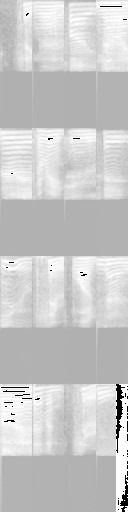

In [47]:
import glob

sample_images = sorted(glob.glob(f"{config.output_dir}/samples/*.png"))
Image.open(sample_images[-1])

# Sample with class

# Samples to Wav 

In [230]:
import glob
import numpy as np
import librosa
import soundfile as sf

new_folder = 'Synth_Wavs/'
os.makedirs(new_folder, exist_ok=True)

# Get a list of all files matching the pattern # TODO: Change pattern to latest gen
file_pattern = 'MNIST_Audio/samples/sample_0147_*.npy'
files = glob.glob(file_pattern)

# Set the sample rate
sr = 52000

# Process and write each file
for file_path in files:
    # Load the mel spectrogram
    melspec_test = np.load(file_path)

    # Reconstruct the audio from the mel spectrogram
    S_reconstructed = librosa.db_to_power(melspec_test)
    y_reconstructed = librosa.feature.inverse.mel_to_audio(S_reconstructed, sr=sr)

    # Create a new file name for the reconstructed audio
    new_file_name = file_path.replace('MNIST_Audio/samples/', 'Synth_Wavs/').replace('.npy', '.wav')

    # Write the reconstructed audio to a new file
    sf.write(new_file_name, y_reconstructed, sr)

    print(f'Processed and saved: {new_file_name}')


Processed and saved: Synth_Wavs/sample_0147_10.wav
Processed and saved: Synth_Wavs/sample_0147_4.wav
Processed and saved: Synth_Wavs/sample_0147_3.wav
Processed and saved: Synth_Wavs/sample_0147_11.wav
Processed and saved: Synth_Wavs/sample_0147_2.wav
Processed and saved: Synth_Wavs/sample_0147_5.wav
Processed and saved: Synth_Wavs/sample_0147_8.wav
Processed and saved: Synth_Wavs/sample_0147_6.wav
Processed and saved: Synth_Wavs/sample_0147_1.wav
Processed and saved: Synth_Wavs/sample_0147_15.wav
Processed and saved: Synth_Wavs/sample_0147_12.wav
Processed and saved: Synth_Wavs/sample_0147_0.wav
Processed and saved: Synth_Wavs/sample_0147_7.wav
Processed and saved: Synth_Wavs/sample_0147_9.wav
Processed and saved: Synth_Wavs/sample_0147_13.wav
Processed and saved: Synth_Wavs/sample_0147_14.wav
